In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']

exclude_labels = (8,9,10)

In [4]:
from torchaffectnet.datasets import AffectNetDatasetForSupCon
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomApply,
                                    ColorJitter,
                                    RandomGrayscale,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

supcon_transform = Compose([
    RandomResizedCrop(size=tuple(feature_extractor.size.values()), scale=(0.2, 1.)),
    RandomHorizontalFlip(),
    RandomApply([
        ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    RandomGrayscale(p=0.2),
    ToTensor(),
    normalize
])

contrastive_dataset = AffectNetDatasetForSupCon('../Affectnet/training.csv',
                                                images_root,
                                                transform=supcon_transform,
                                                exclude_label=exclude_labels,
                                                invalid_files=train_invalid_files)

len(contrastive_dataset)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs

287651

In [13]:
from torch.utils.data import DataLoader
from torchaffectnet.collators import ContrastiveCollator

train_dataloader = DataLoader(contrastive_dataset, collate_fn=ContrastiveCollator(return_labels=True), batch_size=16)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    if k == 'labels':
      print(k, v)
    else:
      print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels tensor([1, 0, 0, 1, 6, 6, 1, 1, 0, 0, 6, 2, 1, 1, 0, 1])


In [6]:
from transformers import Trainer

from SupContrast.losses import SupConLoss

class SupConTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = SupConLoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        bsz = labels.shape[0]
        outputs = model(pixel_values=inputs.get('pixel_values'), output_hidden_states=True)
        features = outputs.get('logits')
        f1, f2 = torch.split(features, [bsz, bsz])
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = self.loss_fct(features, labels)
        return (loss, features) if return_outputs else loss

In [7]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                  num_labels=64,
                                                  problem_type='regression')

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', group='affectnet-contrastive', name='exnone-valencelabel-SupCon-pretrain')

contrastive_args = TrainingArguments(
    f"affectnet-valence-supcon-exnone",
    save_strategy='epoch',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=1e-3,
    logging_dir='contrastive-logs',
    logging_strategy='steps',
    logging_steps=1000,
    remove_unused_columns=False,
    report_to='wandb'
)

trainer = SupConTrainer(
    model,
    contrastive_args,
    train_dataset=contrastive_dataset,
    data_collator=ContrastiveCollator(return_labels=True),
    tokenizer=feature_extractor,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [9]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 1000/179790 [14:10<41:49:10,  1.19it/s]

{'loss': 3.0741, 'learning_rate': 9.944379553924023e-06, 'epoch': 0.06}


  1%|          | 2000/179790 [30:13<38:24:11,  1.29it/s]

{'loss': 2.9732, 'learning_rate': 9.888759107848045e-06, 'epoch': 0.11}


  2%|▏         | 3000/179790 [46:39<44:22:22,  1.11it/s] 

{'loss': 2.9383, 'learning_rate': 9.833138661772067e-06, 'epoch': 0.17}


  2%|▏         | 4000/179790 [1:02:49<43:41:42,  1.12it/s] 

{'loss': 2.9236, 'learning_rate': 9.77751821569609e-06, 'epoch': 0.22}


  3%|▎         | 5000/179790 [1:18:56<53:55:41,  1.11s/it] 

{'loss': 2.9152, 'learning_rate': 9.721897769620114e-06, 'epoch': 0.28}


  3%|▎         | 6000/179790 [1:34:29<42:16:27,  1.14it/s] 

{'loss': 2.9006, 'learning_rate': 9.666277323544136e-06, 'epoch': 0.33}


  4%|▍         | 7000/179790 [1:50:26<44:07:55,  1.09it/s]

{'loss': 2.8872, 'learning_rate': 9.610656877468158e-06, 'epoch': 0.39}


  4%|▍         | 8000/179790 [2:06:07<40:18:13,  1.18it/s]

{'loss': 2.8892, 'learning_rate': 9.55503643139218e-06, 'epoch': 0.44}


  5%|▌         | 9000/179790 [2:22:07<47:28:51,  1.00s/it] 

{'loss': 2.8778, 'learning_rate': 9.499415985316202e-06, 'epoch': 0.5}


  6%|▌         | 10000/179790 [2:37:56<38:07:43,  1.24it/s]

{'loss': 2.8791, 'learning_rate': 9.443795539240226e-06, 'epoch': 0.56}


  6%|▌         | 11000/179790 [2:53:31<35:29:13,  1.32it/s] 

{'loss': 2.8773, 'learning_rate': 9.388175093164249e-06, 'epoch': 0.61}


  7%|▋         | 12000/179790 [3:08:59<40:48:32,  1.14it/s]

{'loss': 2.8612, 'learning_rate': 9.33255464708827e-06, 'epoch': 0.67}


  7%|▋         | 13000/179790 [3:24:42<41:59:58,  1.10it/s] 

{'loss': 2.8672, 'learning_rate': 9.276934201012293e-06, 'epoch': 0.72}


  8%|▊         | 14000/179790 [3:42:05<36:34:23,  1.26it/s] 

{'loss': 2.8579, 'learning_rate': 9.221313754936315e-06, 'epoch': 0.78}


  8%|▊         | 15000/179790 [3:58:22<63:16:04,  1.38s/it] 

{'loss': 2.8744, 'learning_rate': 9.165693308860337e-06, 'epoch': 0.83}


  9%|▉         | 16000/179790 [4:14:06<37:38:32,  1.21it/s] 

{'loss': 2.8582, 'learning_rate': 9.110072862784361e-06, 'epoch': 0.89}


  9%|▉         | 17000/179790 [4:31:06<44:40:50,  1.01it/s] 

{'loss': 2.8423, 'learning_rate': 9.054452416708382e-06, 'epoch': 0.95}


 10%|█         | 18000/179790 [4:46:29<38:10:19,  1.18it/s] 

{'loss': 2.8324, 'learning_rate': 8.998831970632406e-06, 'epoch': 1.0}


 11%|█         | 19000/179790 [4:59:26<34:11:24,  1.31it/s]

{'loss': 2.8446, 'learning_rate': 8.943211524556428e-06, 'epoch': 1.06}


 11%|█         | 20000/179790 [5:12:30<36:31:21,  1.22it/s]

{'loss': 2.8359, 'learning_rate': 8.88759107848045e-06, 'epoch': 1.11}


 12%|█▏        | 21000/179790 [5:25:55<34:26:41,  1.28it/s]

{'loss': 2.8335, 'learning_rate': 8.831970632404472e-06, 'epoch': 1.17}


 12%|█▏        | 22000/179790 [5:39:38<35:58:40,  1.22it/s]

{'loss': 2.8405, 'learning_rate': 8.776350186328494e-06, 'epoch': 1.22}


 13%|█▎        | 23000/179790 [5:53:32<36:08:22,  1.21it/s]

{'loss': 2.8177, 'learning_rate': 8.720729740252517e-06, 'epoch': 1.28}


 13%|█▎        | 24000/179790 [6:07:01<34:51:16,  1.24it/s]

{'loss': 2.8256, 'learning_rate': 8.66510929417654e-06, 'epoch': 1.33}


 14%|█▍        | 25000/179790 [6:20:30<35:56:21,  1.20it/s]

{'loss': 2.8323, 'learning_rate': 8.609488848100563e-06, 'epoch': 1.39}


 14%|█▍        | 26000/179790 [6:34:01<34:26:11,  1.24it/s]

{'loss': 2.8208, 'learning_rate': 8.553868402024585e-06, 'epoch': 1.45}


 15%|█▌        | 27000/179790 [6:47:33<34:56:04,  1.21it/s]

{'loss': 2.8319, 'learning_rate': 8.498247955948607e-06, 'epoch': 1.5}


 16%|█▌        | 28000/179790 [7:01:04<32:40:13,  1.29it/s]

{'loss': 2.8353, 'learning_rate': 8.44262750987263e-06, 'epoch': 1.56}


 16%|█▌        | 29000/179790 [7:14:29<34:05:21,  1.23it/s]

{'loss': 2.8111, 'learning_rate': 8.387007063796653e-06, 'epoch': 1.61}


 17%|█▋        | 30000/179790 [7:27:57<35:58:41,  1.16it/s]

{'loss': 2.8201, 'learning_rate': 8.331386617720676e-06, 'epoch': 1.67}


 17%|█▋        | 31000/179790 [7:41:35<31:30:00,  1.31it/s]

{'loss': 2.8267, 'learning_rate': 8.275766171644696e-06, 'epoch': 1.72}


 18%|█▊        | 32000/179790 [7:55:09<34:40:39,  1.18it/s]

{'loss': 2.8155, 'learning_rate': 8.22014572556872e-06, 'epoch': 1.78}


 18%|█▊        | 33000/179790 [8:08:52<33:13:24,  1.23it/s]

{'loss': 2.8198, 'learning_rate': 8.164525279492742e-06, 'epoch': 1.84}


 19%|█▉        | 34000/179790 [8:22:32<35:31:15,  1.14it/s]

{'loss': 2.8038, 'learning_rate': 8.108904833416764e-06, 'epoch': 1.89}


 19%|█▉        | 35000/179790 [8:35:56<35:17:59,  1.14it/s]

{'loss': 2.8031, 'learning_rate': 8.053284387340787e-06, 'epoch': 1.95}


 20%|██        | 36000/179790 [8:49:35<31:22:01,  1.27it/s]

{'loss': 2.8075, 'learning_rate': 7.997663941264809e-06, 'epoch': 2.0}


 21%|██        | 37000/179790 [9:02:28<30:39:43,  1.29it/s]

{'loss': 2.7955, 'learning_rate': 7.942043495188833e-06, 'epoch': 2.06}


 21%|██        | 38000/179790 [9:15:36<32:45:27,  1.20it/s]

{'loss': 2.8121, 'learning_rate': 7.886423049112855e-06, 'epoch': 2.11}


 22%|██▏       | 39000/179790 [9:28:59<30:36:24,  1.28it/s]

{'loss': 2.8064, 'learning_rate': 7.830802603036877e-06, 'epoch': 2.17}


 22%|██▏       | 40000/179790 [9:42:50<32:02:42,  1.21it/s]

{'loss': 2.8035, 'learning_rate': 7.7751821569609e-06, 'epoch': 2.22}


 23%|██▎       | 41000/179790 [9:56:26<31:53:21,  1.21it/s]

{'loss': 2.7971, 'learning_rate': 7.719561710884922e-06, 'epoch': 2.28}


 23%|██▎       | 42000/179790 [10:10:01<32:58:07,  1.16it/s]

{'loss': 2.8069, 'learning_rate': 7.663941264808944e-06, 'epoch': 2.34}


 24%|██▍       | 43000/179790 [10:24:54<35:55:51,  1.06it/s]

{'loss': 2.7819, 'learning_rate': 7.608320818732967e-06, 'epoch': 2.39}


 24%|██▍       | 44000/179790 [10:38:39<29:03:30,  1.30it/s]

{'loss': 2.7926, 'learning_rate': 7.552700372656989e-06, 'epoch': 2.45}


 25%|██▌       | 45000/179790 [10:52:17<31:43:00,  1.18it/s]

{'loss': 2.7899, 'learning_rate': 7.497079926581011e-06, 'epoch': 2.5}


 26%|██▌       | 46000/179790 [11:05:48<29:11:18,  1.27it/s]

{'loss': 2.7978, 'learning_rate': 7.441459480505034e-06, 'epoch': 2.56}


 26%|██▌       | 47000/179790 [11:19:28<29:59:32,  1.23it/s]

{'loss': 2.7879, 'learning_rate': 7.3858390344290565e-06, 'epoch': 2.61}


 27%|██▋       | 48000/179790 [11:33:06<29:08:50,  1.26it/s]

{'loss': 2.7975, 'learning_rate': 7.3302185883530796e-06, 'epoch': 2.67}


 27%|██▋       | 49000/179790 [11:46:41<29:01:14,  1.25it/s]

{'loss': 2.7964, 'learning_rate': 7.274598142277102e-06, 'epoch': 2.73}


 28%|██▊       | 50000/179790 [12:00:11<31:29:26,  1.14it/s]

{'loss': 2.797, 'learning_rate': 7.218977696201124e-06, 'epoch': 2.78}


 28%|██▊       | 51000/179790 [12:13:45<29:03:50,  1.23it/s]

{'loss': 2.8066, 'learning_rate': 7.163357250125147e-06, 'epoch': 2.84}


 29%|██▉       | 52000/179790 [12:27:18<29:38:30,  1.20it/s]

{'loss': 2.7779, 'learning_rate': 7.107736804049169e-06, 'epoch': 2.89}


 29%|██▉       | 53000/179790 [12:40:45<27:54:18,  1.26it/s]

{'loss': 2.7855, 'learning_rate': 7.0521163579731915e-06, 'epoch': 2.95}


 30%|███       | 54000/179790 [12:54:15<27:38:56,  1.26it/s]

{'loss': 2.7917, 'learning_rate': 6.9964959118972145e-06, 'epoch': 3.0}


 31%|███       | 55000/179790 [13:07:18<25:34:35,  1.36it/s]

{'loss': 2.7896, 'learning_rate': 6.940875465821236e-06, 'epoch': 3.06}


 31%|███       | 56000/179790 [13:20:39<27:12:58,  1.26it/s]

{'loss': 2.7791, 'learning_rate': 6.88525501974526e-06, 'epoch': 3.11}


 32%|███▏      | 57000/179790 [13:34:07<28:32:41,  1.19it/s]

{'loss': 2.7797, 'learning_rate': 6.829634573669281e-06, 'epoch': 3.17}


 32%|███▏      | 58000/179790 [13:48:02<27:35:21,  1.23it/s]

{'loss': 2.7924, 'learning_rate': 6.774014127593303e-06, 'epoch': 3.23}


 33%|███▎      | 59000/179790 [14:01:43<26:03:59,  1.29it/s]

{'loss': 2.7881, 'learning_rate': 6.718393681517326e-06, 'epoch': 3.28}


 33%|███▎      | 60000/179790 [14:15:18<27:39:38,  1.20it/s]

{'loss': 2.7818, 'learning_rate': 6.662773235441349e-06, 'epoch': 3.34}


 34%|███▍      | 61000/179790 [14:28:58<28:07:49,  1.17it/s]

{'loss': 2.791, 'learning_rate': 6.607152789365371e-06, 'epoch': 3.39}


 34%|███▍      | 62000/179790 [14:42:32<25:35:53,  1.28it/s]

{'loss': 2.7648, 'learning_rate': 6.551532343289394e-06, 'epoch': 3.45}


 35%|███▌      | 63000/179790 [14:55:58<25:45:19,  1.26it/s]

{'loss': 2.7924, 'learning_rate': 6.495911897213416e-06, 'epoch': 3.5}


 36%|███▌      | 64000/179790 [15:09:52<24:26:27,  1.32it/s]

{'loss': 2.7829, 'learning_rate': 6.440291451137438e-06, 'epoch': 3.56}


 36%|███▌      | 65000/179790 [15:23:19<25:17:46,  1.26it/s]

{'loss': 2.7803, 'learning_rate': 6.384671005061461e-06, 'epoch': 3.62}


 37%|███▋      | 66000/179790 [15:36:47<24:38:41,  1.28it/s]

{'loss': 2.7776, 'learning_rate': 6.3290505589854836e-06, 'epoch': 3.67}


 37%|███▋      | 67000/179790 [15:50:10<25:40:27,  1.22it/s]

{'loss': 2.7758, 'learning_rate': 6.273430112909507e-06, 'epoch': 3.73}


 38%|███▊      | 68000/179790 [16:03:36<24:37:39,  1.26it/s]

{'loss': 2.7811, 'learning_rate': 6.217809666833529e-06, 'epoch': 3.78}


 38%|███▊      | 69000/179790 [16:17:07<27:05:35,  1.14it/s]

{'loss': 2.7705, 'learning_rate': 6.162189220757551e-06, 'epoch': 3.84}


 39%|███▉      | 70000/179790 [16:30:32<25:22:35,  1.20it/s]

{'loss': 2.7802, 'learning_rate': 6.106568774681574e-06, 'epoch': 3.89}


 39%|███▉      | 71000/179790 [16:43:59<24:37:12,  1.23it/s]

{'loss': 2.774, 'learning_rate': 6.050948328605596e-06, 'epoch': 3.95}


 40%|████      | 72000/179790 [16:57:43<21:35:04,  1.39it/s]

{'loss': 2.764, 'learning_rate': 5.995327882529618e-06, 'epoch': 4.0}


 41%|████      | 73000/179790 [17:11:20<23:05:19,  1.28it/s]

{'loss': 2.7666, 'learning_rate': 5.939707436453641e-06, 'epoch': 4.06}


 41%|████      | 74000/179790 [17:25:38<30:31:42,  1.04s/it]

{'loss': 2.7636, 'learning_rate': 5.884086990377663e-06, 'epoch': 4.12}


 42%|████▏     | 75000/179790 [17:39:51<24:25:43,  1.19it/s]

{'loss': 2.7692, 'learning_rate': 5.828466544301685e-06, 'epoch': 4.17}


 42%|████▏     | 76000/179790 [17:54:03<23:19:55,  1.24it/s]

{'loss': 2.7754, 'learning_rate': 5.772846098225708e-06, 'epoch': 4.23}


 43%|████▎     | 77000/179790 [18:07:50<22:46:08,  1.25it/s]

{'loss': 2.7628, 'learning_rate': 5.71722565214973e-06, 'epoch': 4.28}


 43%|████▎     | 78000/179790 [18:21:39<23:48:24,  1.19it/s]

{'loss': 2.7635, 'learning_rate': 5.6616052060737535e-06, 'epoch': 4.34}


 44%|████▍     | 79000/179790 [18:35:20<23:35:44,  1.19it/s]

{'loss': 2.764, 'learning_rate': 5.605984759997776e-06, 'epoch': 4.39}


 44%|████▍     | 80000/179790 [18:49:08<30:27:08,  1.10s/it]

{'loss': 2.7692, 'learning_rate': 5.550364313921798e-06, 'epoch': 4.45}


 45%|████▌     | 81000/179790 [19:02:56<24:51:21,  1.10it/s]

{'loss': 2.7657, 'learning_rate': 5.494743867845821e-06, 'epoch': 4.51}


 46%|████▌     | 82000/179790 [19:16:32<24:03:29,  1.13it/s]

{'loss': 2.7644, 'learning_rate': 5.439123421769843e-06, 'epoch': 4.56}


 46%|████▌     | 83000/179790 [19:30:07<21:36:12,  1.24it/s]

{'loss': 2.7743, 'learning_rate': 5.383502975693865e-06, 'epoch': 4.62}


 47%|████▋     | 84000/179790 [19:44:04<21:09:57,  1.26it/s]

{'loss': 2.7841, 'learning_rate': 5.327882529617888e-06, 'epoch': 4.67}


 47%|████▋     | 85000/179790 [19:57:33<20:43:09,  1.27it/s]

{'loss': 2.7596, 'learning_rate': 5.272262083541911e-06, 'epoch': 4.73}


 48%|████▊     | 86000/179790 [20:11:13<21:09:27,  1.23it/s]

{'loss': 2.7617, 'learning_rate': 5.216641637465934e-06, 'epoch': 4.78}


 48%|████▊     | 87000/179790 [20:24:43<21:50:46,  1.18it/s]

{'loss': 2.7573, 'learning_rate': 5.161021191389956e-06, 'epoch': 4.84}


 49%|████▉     | 88000/179790 [20:38:11<19:50:12,  1.29it/s]

{'loss': 2.7623, 'learning_rate': 5.105400745313977e-06, 'epoch': 4.89}


 50%|████▉     | 89000/179790 [20:51:40<20:16:46,  1.24it/s]

{'loss': 2.7645, 'learning_rate': 5.049780299238001e-06, 'epoch': 4.95}


 50%|█████     | 90000/179790 [21:05:36<18:23:40,  1.36it/s]

{'loss': 2.7639, 'learning_rate': 4.9941598531620225e-06, 'epoch': 5.01}


 51%|█████     | 91000/179790 [21:18:32<19:23:53,  1.27it/s]

{'loss': 2.7545, 'learning_rate': 4.9385394070860456e-06, 'epoch': 5.06}


 51%|█████     | 92000/179790 [21:32:01<20:01:36,  1.22it/s]

{'loss': 2.7714, 'learning_rate': 4.882918961010068e-06, 'epoch': 5.12}


 52%|█████▏    | 93000/179790 [21:45:42<21:40:33,  1.11it/s]

{'loss': 2.7665, 'learning_rate': 4.82729851493409e-06, 'epoch': 5.17}


 52%|█████▏    | 94000/179790 [22:00:05<20:11:55,  1.18it/s]

{'loss': 2.7495, 'learning_rate': 4.771678068858113e-06, 'epoch': 5.23}


 53%|█████▎    | 95000/179790 [22:14:00<17:02:05,  1.38it/s]

{'loss': 2.7628, 'learning_rate': 4.716057622782135e-06, 'epoch': 5.28}


 53%|█████▎    | 96000/179790 [22:27:00<20:19:39,  1.14it/s]

{'loss': 2.757, 'learning_rate': 4.6604371767061575e-06, 'epoch': 5.34}


 54%|█████▍    | 97000/179790 [22:40:58<18:29:00,  1.24it/s]

{'loss': 2.745, 'learning_rate': 4.60481673063018e-06, 'epoch': 5.4}


 55%|█████▍    | 98000/179790 [22:54:42<17:20:57,  1.31it/s]

{'loss': 2.7661, 'learning_rate': 4.549196284554203e-06, 'epoch': 5.45}


 55%|█████▌    | 99000/179790 [23:08:18<17:57:11,  1.25it/s]

{'loss': 2.7656, 'learning_rate': 4.493575838478225e-06, 'epoch': 5.51}


 56%|█████▌    | 100000/179790 [23:22:21<17:32:12,  1.26it/s]

{'loss': 2.7544, 'learning_rate': 4.437955392402247e-06, 'epoch': 5.56}


 56%|█████▌    | 101000/179790 [23:36:06<18:52:54,  1.16it/s]

{'loss': 2.7546, 'learning_rate': 4.38233494632627e-06, 'epoch': 5.62}


 57%|█████▋    | 102000/179790 [23:50:01<17:54:49,  1.21it/s]

{'loss': 2.7517, 'learning_rate': 4.326714500250292e-06, 'epoch': 5.67}


 57%|█████▋    | 103000/179790 [24:04:03<16:48:32,  1.27it/s]

{'loss': 2.7475, 'learning_rate': 4.271094054174315e-06, 'epoch': 5.73}


 58%|█████▊    | 104000/179790 [24:17:57<17:25:21,  1.21it/s]

{'loss': 2.7542, 'learning_rate': 4.215473608098337e-06, 'epoch': 5.78}


 58%|█████▊    | 105000/179790 [24:31:54<16:41:42,  1.24it/s]

{'loss': 2.7504, 'learning_rate': 4.15985316202236e-06, 'epoch': 5.84}


 59%|█████▉    | 106000/179790 [24:45:59<18:17:22,  1.12it/s]

{'loss': 2.7571, 'learning_rate': 4.104232715946382e-06, 'epoch': 5.9}


 60%|█████▉    | 107000/179790 [25:00:04<15:51:16,  1.28it/s]

{'loss': 2.741, 'learning_rate': 4.048612269870404e-06, 'epoch': 5.95}


 60%|██████    | 108000/179790 [25:14:18<16:30:40,  1.21it/s]

{'loss': 2.7486, 'learning_rate': 3.992991823794427e-06, 'epoch': 6.01}


 61%|██████    | 109000/179790 [25:28:08<15:21:44,  1.28it/s]

{'loss': 2.7492, 'learning_rate': 3.9373713777184496e-06, 'epoch': 6.06}


 61%|██████    | 110000/179790 [25:42:04<14:40:27,  1.32it/s]

{'loss': 2.7448, 'learning_rate': 3.881750931642473e-06, 'epoch': 6.12}


 62%|██████▏   | 111000/179790 [25:56:32<15:40:00,  1.22it/s]

{'loss': 2.7452, 'learning_rate': 3.826130485566494e-06, 'epoch': 6.17}


 62%|██████▏   | 112000/179790 [26:11:26<18:03:53,  1.04it/s]

{'loss': 2.7408, 'learning_rate': 3.770510039490517e-06, 'epoch': 6.23}


 63%|██████▎   | 113000/179790 [26:26:12<15:55:09,  1.17it/s]

{'loss': 2.7465, 'learning_rate': 3.7148895934145397e-06, 'epoch': 6.29}


 63%|██████▎   | 114000/179790 [26:41:11<15:59:06,  1.14it/s]

{'loss': 2.7582, 'learning_rate': 3.6592691473385623e-06, 'epoch': 6.34}


 64%|██████▍   | 115000/179790 [26:57:00<14:38:47,  1.23it/s]

{'loss': 2.7419, 'learning_rate': 3.603648701262584e-06, 'epoch': 6.4}


 65%|██████▍   | 116000/179790 [27:12:26<14:40:38,  1.21it/s]

{'loss': 2.7456, 'learning_rate': 3.5480282551866067e-06, 'epoch': 6.45}


 65%|██████▌   | 117000/179790 [27:27:53<17:50:39,  1.02s/it]

{'loss': 2.7423, 'learning_rate': 3.4924078091106293e-06, 'epoch': 6.51}


 66%|██████▌   | 118000/179790 [27:43:33<14:45:01,  1.16it/s]

{'loss': 2.7474, 'learning_rate': 3.4367873630346516e-06, 'epoch': 6.56}


 66%|██████▌   | 119000/179790 [27:58:50<14:33:56,  1.16it/s]

{'loss': 2.7392, 'learning_rate': 3.381166916958674e-06, 'epoch': 6.62}


 67%|██████▋   | 120000/179790 [28:14:47<13:31:05,  1.23it/s]

{'loss': 2.7491, 'learning_rate': 3.325546470882697e-06, 'epoch': 6.67}


 67%|██████▋   | 121000/179790 [28:30:50<15:02:15,  1.09it/s]

{'loss': 2.7555, 'learning_rate': 3.2699260248067195e-06, 'epoch': 6.73}


 68%|██████▊   | 122000/179790 [28:47:45<15:35:17,  1.03it/s]

{'loss': 2.7386, 'learning_rate': 3.2143055787307412e-06, 'epoch': 6.79}


 68%|██████▊   | 123000/179790 [29:13:52<13:35:58,  1.16it/s] 

{'loss': 2.7375, 'learning_rate': 3.158685132654764e-06, 'epoch': 6.84}


 69%|██████▉   | 124000/179790 [29:34:11<12:22:31,  1.25it/s]

{'loss': 2.7402, 'learning_rate': 3.1030646865787865e-06, 'epoch': 6.9}


 70%|██████▉   | 125000/179790 [29:54:34<12:54:18,  1.18it/s]

{'loss': 2.752, 'learning_rate': 3.047444240502809e-06, 'epoch': 6.95}


 70%|███████   | 126000/179790 [30:12:17<11:00:52,  1.36it/s]

{'loss': 2.7421, 'learning_rate': 2.9918237944268313e-06, 'epoch': 7.01}


 71%|███████   | 127000/179790 [30:27:04<11:31:31,  1.27it/s]

{'loss': 2.7393, 'learning_rate': 2.936203348350854e-06, 'epoch': 7.06}


 71%|███████   | 128000/179790 [30:41:34<13:18:18,  1.08it/s]

{'loss': 2.7322, 'learning_rate': 2.8805829022748766e-06, 'epoch': 7.12}


 72%|███████▏  | 129000/179790 [30:56:09<11:23:10,  1.24it/s]

{'loss': 2.7485, 'learning_rate': 2.8249624561988992e-06, 'epoch': 7.18}


 72%|███████▏  | 130000/179790 [31:10:52<11:18:42,  1.22it/s]

{'loss': 2.7372, 'learning_rate': 2.7693420101229215e-06, 'epoch': 7.23}


 73%|███████▎  | 131000/179790 [31:25:39<11:06:58,  1.22it/s]

{'loss': 2.7454, 'learning_rate': 2.7137215640469437e-06, 'epoch': 7.29}


 73%|███████▎  | 132000/179790 [31:40:08<12:00:30,  1.11it/s]

{'loss': 2.7468, 'learning_rate': 2.6581011179709663e-06, 'epoch': 7.34}


 74%|███████▍  | 133000/179790 [31:54:56<22:32:07,  1.73s/it]

{'loss': 2.7406, 'learning_rate': 2.6024806718949885e-06, 'epoch': 7.4}


 75%|███████▍  | 134000/179790 [32:09:21<9:51:50,  1.29it/s] 

{'loss': 2.7379, 'learning_rate': 2.546860225819011e-06, 'epoch': 7.45}


 75%|███████▌  | 135000/179790 [32:24:14<10:29:55,  1.19it/s]

{'loss': 2.7362, 'learning_rate': 2.4912397797430338e-06, 'epoch': 7.51}


 76%|███████▌  | 136000/179790 [32:38:48<9:35:27,  1.27it/s] 

{'loss': 2.7411, 'learning_rate': 2.435619333667056e-06, 'epoch': 7.56}


 76%|███████▌  | 137000/179790 [32:53:26<10:19:07,  1.15it/s]

{'loss': 2.7461, 'learning_rate': 2.3799988875910786e-06, 'epoch': 7.62}


 77%|███████▋  | 138000/179790 [33:08:30<9:52:26,  1.18it/s] 

{'loss': 2.7294, 'learning_rate': 2.3243784415151012e-06, 'epoch': 7.68}


 77%|███████▋  | 139000/179790 [33:23:30<9:44:32,  1.16it/s] 

{'loss': 2.7423, 'learning_rate': 2.268757995439124e-06, 'epoch': 7.73}


 78%|███████▊  | 140000/179790 [33:38:21<8:44:24,  1.26it/s] 

{'loss': 2.7316, 'learning_rate': 2.213137549363146e-06, 'epoch': 7.79}


 78%|███████▊  | 141000/179790 [33:53:07<8:41:15,  1.24it/s] 

{'loss': 2.745, 'learning_rate': 2.1575171032871687e-06, 'epoch': 7.84}


 79%|███████▉  | 142000/179790 [34:07:34<8:09:04,  1.29it/s] 

{'loss': 2.7328, 'learning_rate': 2.101896657211191e-06, 'epoch': 7.9}


 80%|███████▉  | 143000/179790 [34:21:51<8:19:11,  1.23it/s] 

{'loss': 2.7426, 'learning_rate': 2.0462762111352136e-06, 'epoch': 7.95}


 80%|████████  | 144000/179790 [34:36:17<7:55:18,  1.25it/s] 

{'loss': 2.738, 'learning_rate': 1.9906557650592358e-06, 'epoch': 8.01}


 81%|████████  | 145000/179790 [34:49:26<8:11:52,  1.18it/s] 

{'loss': 2.7235, 'learning_rate': 1.9350353189832584e-06, 'epoch': 8.06}


 81%|████████  | 146000/179790 [35:02:52<7:17:20,  1.29it/s] 

{'loss': 2.7271, 'learning_rate': 1.8794148729072808e-06, 'epoch': 8.12}


 82%|████████▏ | 147000/179790 [35:16:51<7:20:45,  1.24it/s] 

{'loss': 2.7328, 'learning_rate': 1.8237944268313032e-06, 'epoch': 8.18}


 82%|████████▏ | 148000/179790 [35:30:47<7:12:17,  1.23it/s] 

{'loss': 2.7301, 'learning_rate': 1.7681739807553259e-06, 'epoch': 8.23}


 83%|████████▎ | 149000/179790 [35:44:33<7:33:25,  1.13it/s] 

{'loss': 2.7301, 'learning_rate': 1.712553534679348e-06, 'epoch': 8.29}


 83%|████████▎ | 150000/179790 [35:58:58<6:48:00,  1.22it/s] 

{'loss': 2.726, 'learning_rate': 1.6569330886033707e-06, 'epoch': 8.34}


 84%|████████▍ | 151000/179790 [36:12:47<7:13:22,  1.11it/s] 

{'loss': 2.7288, 'learning_rate': 1.6013126425273931e-06, 'epoch': 8.4}


 85%|████████▍ | 152000/179790 [36:26:23<6:01:54,  1.28it/s]

{'loss': 2.7299, 'learning_rate': 1.5456921964514158e-06, 'epoch': 8.45}


 85%|████████▌ | 153000/179790 [36:39:55<6:02:07,  1.23it/s] 

{'loss': 2.739, 'learning_rate': 1.490071750375438e-06, 'epoch': 8.51}


 86%|████████▌ | 154000/179790 [36:53:39<5:48:05,  1.23it/s] 

{'loss': 2.7217, 'learning_rate': 1.4344513042994606e-06, 'epoch': 8.57}


 86%|████████▌ | 155000/179790 [37:07:13<5:32:52,  1.24it/s]

{'loss': 2.7276, 'learning_rate': 1.378830858223483e-06, 'epoch': 8.62}


 87%|████████▋ | 156000/179790 [37:20:40<5:12:01,  1.27it/s]

{'loss': 2.7454, 'learning_rate': 1.3232104121475057e-06, 'epoch': 8.68}


 87%|████████▋ | 157000/179790 [37:34:13<5:25:48,  1.17it/s]

{'loss': 2.7384, 'learning_rate': 1.2675899660715279e-06, 'epoch': 8.73}


 88%|████████▊ | 158000/179790 [37:47:52<4:56:52,  1.22it/s]

{'loss': 2.7262, 'learning_rate': 1.2119695199955505e-06, 'epoch': 8.79}


 88%|████████▊ | 159000/179790 [38:01:58<4:35:25,  1.26it/s]

{'loss': 2.7261, 'learning_rate': 1.156349073919573e-06, 'epoch': 8.84}


 89%|████████▉ | 160000/179790 [38:15:48<4:20:15,  1.27it/s]

{'loss': 2.7318, 'learning_rate': 1.1007286278435953e-06, 'epoch': 8.9}


 90%|████████▉ | 161000/179790 [38:29:27<4:10:04,  1.25it/s]

{'loss': 2.7282, 'learning_rate': 1.0451081817676178e-06, 'epoch': 8.95}


 90%|█████████ | 162000/179790 [38:43:09<3:39:11,  1.35it/s]

{'loss': 2.7321, 'learning_rate': 9.894877356916404e-07, 'epoch': 9.01}


 91%|█████████ | 163000/179790 [38:56:20<3:41:03,  1.27it/s]

{'loss': 2.7206, 'learning_rate': 9.338672896156628e-07, 'epoch': 9.07}


 91%|█████████ | 164000/179790 [39:10:14<3:37:06,  1.21it/s]

{'loss': 2.7213, 'learning_rate': 8.782468435396852e-07, 'epoch': 9.12}


 92%|█████████▏| 165000/179790 [39:23:49<3:18:56,  1.24it/s]

{'loss': 2.7164, 'learning_rate': 8.226263974637078e-07, 'epoch': 9.18}


 92%|█████████▏| 166000/179790 [39:37:34<3:12:21,  1.19it/s]

{'loss': 2.716, 'learning_rate': 7.670059513877302e-07, 'epoch': 9.23}


 93%|█████████▎| 167000/179790 [39:51:25<2:50:41,  1.25it/s]

{'loss': 2.7266, 'learning_rate': 7.113855053117527e-07, 'epoch': 9.29}


 93%|█████████▎| 168000/179790 [40:05:11<2:42:26,  1.21it/s]

{'loss': 2.7331, 'learning_rate': 6.557650592357751e-07, 'epoch': 9.34}


 94%|█████████▍| 169000/179790 [40:18:47<2:24:04,  1.25it/s]

{'loss': 2.7257, 'learning_rate': 6.001446131597976e-07, 'epoch': 9.4}


 95%|█████████▍| 170000/179790 [40:32:22<2:07:01,  1.28it/s]

{'loss': 2.73, 'learning_rate': 5.445241670838201e-07, 'epoch': 9.46}


 95%|█████████▌| 171000/179790 [40:46:06<1:51:43,  1.31it/s]

{'loss': 2.7169, 'learning_rate': 4.889037210078425e-07, 'epoch': 9.51}


 96%|█████████▌| 172000/179790 [40:59:41<1:44:38,  1.24it/s]

{'loss': 2.7236, 'learning_rate': 4.3328327493186503e-07, 'epoch': 9.57}


 96%|█████████▌| 173000/179790 [41:13:12<1:33:48,  1.21it/s]

{'loss': 2.7276, 'learning_rate': 3.776628288558874e-07, 'epoch': 9.62}


 97%|█████████▋| 174000/179790 [41:26:46<1:25:39,  1.13it/s]

{'loss': 2.7198, 'learning_rate': 3.220423827799099e-07, 'epoch': 9.68}


 97%|█████████▋| 175000/179790 [41:40:23<1:04:20,  1.24it/s]

{'loss': 2.6982, 'learning_rate': 2.664219367039324e-07, 'epoch': 9.73}


 98%|█████████▊| 176000/179790 [41:53:56<1:00:39,  1.04it/s]

{'loss': 2.7224, 'learning_rate': 2.1080149062795485e-07, 'epoch': 9.79}


 98%|█████████▊| 177000/179790 [42:07:29<37:06,  1.25it/s]  

{'loss': 2.7293, 'learning_rate': 1.5518104455197732e-07, 'epoch': 9.84}


 99%|█████████▉| 178000/179790 [42:21:02<23:50,  1.25it/s]

{'loss': 2.7132, 'learning_rate': 9.956059847599978e-08, 'epoch': 9.9}


100%|█████████▉| 179000/179790 [42:34:33<10:53,  1.21it/s]

{'loss': 2.7205, 'learning_rate': 4.394015240002225e-08, 'epoch': 9.96}


100%|██████████| 179790/179790 [42:45:11<00:00,  1.55it/s]

{'train_runtime': 153911.4033, 'train_samples_per_second': 18.689, 'train_steps_per_second': 1.168, 'train_loss': 2.7755183429061336, 'epoch': 10.0}


100%|██████████| 179790/179790 [42:45:13<00:00,  1.17it/s]


TrainOutput(global_step=179790, training_loss=2.7755183429061336, metrics={'train_runtime': 153911.4033, 'train_samples_per_second': 18.689, 'train_steps_per_second': 1.168, 'train_loss': 2.7755183429061336, 'epoch': 10.0})

In [10]:
trainer.save_state()
trainer.save_model()

In [14]:
from torchaffectnet.datasets import AffectNetDataset

class AffectNetDatasetForSupConWithValence(AffectNetDatasetForSupCon):
    def labeling(self, idx):
        target = torch.tensor(self.df['valence'][idx])
        if target < -0.5:
            return torch.tensor(0)
        elif target > 0.5:
            return torch.tensor(2)
        else:
            return torch.tensor(1)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])

val_label_dataset = AffectNetDataset('../Affectnet/validation.csv',
                                     images_root,
                                     exclude_label=exclude_labels,
                                     transform=transform)

val_valence_dataset = AffectNetDatasetForSupConWithValence('../Affectnet/validation.csv',
                                                           images_root,
                                                           exclude_label=exclude_labels,
                                                           transform=transform)

In [32]:
from tqdm import tqdm
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random



def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)


def plot_tokens(tokens, labels, n_neighbors, id2label):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 0.5))
    plt.show()

In [33]:
id2label = {0: 'Neutral',
            1: 'Happy',
            2: 'Sad',
            3: 'Surprise',
            4: 'Fear',
            5: 'Disgust',
            6: 'Anger',
            7: 'Contempt'}

labeled_valence = {
    0: 'valence < -0.5',
    1: '-0.5 <= valence <= 0.5',
    2: '0.5 < valence',
}

100%|██████████| 4000/4000 [03:32<00:00, 18.81it/s]


(4000, 2)
(4000,)


/tmp/ipykernel_1086137/4046857062.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


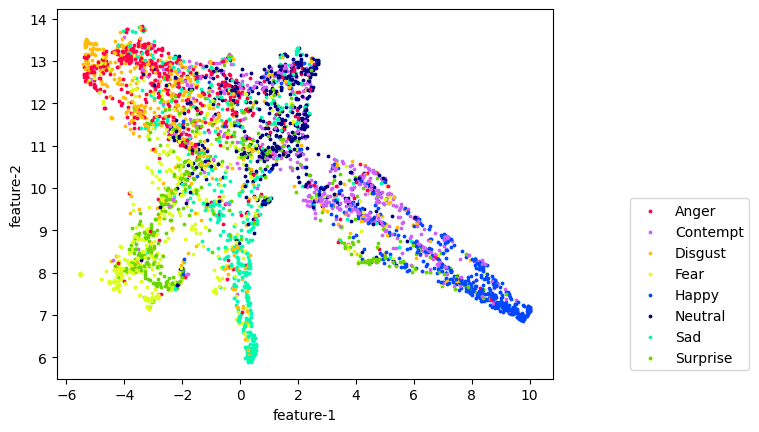

In [34]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_label_dataset,
                            device)
plot_tokens(tokens, labels, 20, id2label)

100%|██████████| 4000/4000 [06:15<00:00, 10.64it/s]


(4000, 2)
(4000,)


/tmp/ipykernel_1086137/4046857062.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


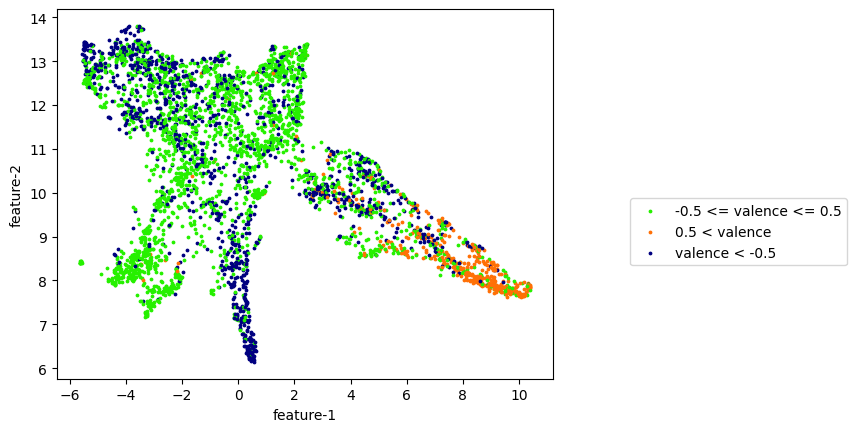

In [36]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_valence_dataset,
                            device)
plot_tokens(tokens, labels, 20, labeled_valence)